
#### 1st assignment by:
- Leonardo Bocchi: leonardo.bocchi.205@gmail.com
- Gerard Castro: gcastrca25@alumnes.ub.edu

<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2023 - Homework 01</h1>

<h3 style="color:blue">2023-03-27</h3>

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

<h1 style="color:blue">Instructions</h1>

### Submissions: 

By **groups** of _about_ three students (meaning: two is OK, four is not advisable but possible. Individual homeworks 
will also be accepted but collaborative work is preferable). 

Please send me an **email** with the team members names as soon as you have formed it.

Only **one copy** of each group's work must be uploaded (by any member)

**Full names** and **email address** of all team members must appear in the header. 

### Format: 

A Jupyter or R Markdown **notebook,** with a **header** clearly stating the names of all contributors. 

### Documentation: 

Comments **in code cells** (e.g., meaning of variables, parameters, purpose of functions) are necessary but not sufficient.

You are expected to give full explanations of steps taken in your solution (in **Markdown cells**), as well as discussion of results and their meaning.

Do not be afraid of being too verbose or too elementary, explain as if to someone learning.

### External sources

Getting _inspiration_ from any book, document, blog, web page, even mimicking solutions given in there, is **allowed and encouraged,** provided you give a **proper reference,** understand every such material, and explain it in you own words, even more exhaustively.

Do not **copy/paste literally large chunks of code** I will detect it, believe me, even missing source reference. Bleak consequences.

### Deadline:

Completed assignments are due on Monday, April 17. They are to be uploaded to the Virtual Campus.

-------------------------------------------------------------------------------
# Exercise 1
-------------------------------------------------------------------------------

## Statement

<h1 style="color:blue">01 - Stan version of a conjugate prior problem</h1>

<h2 style="color:blue">Modelling Earthquake Waiting Times</h2>

Consider the problem in `Exponential.02.Earthquake` (notebook in 2023-03-27 folder), where the goal is to study earthquake waiting times.

Likelihood is modelled as an $\expdist(\lambda)$ and $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$.

In the `Exponential.02.Earthquake` notebook some simulations are performed for:

01. Prior pdf for $\lambda$.
02. Prior predictive pdf for the waiting time.
03. Posterior pdf for $\lambda$.
04. Posterior predictive for new waiting time.

using known theoretical (analytical) descriptions of these distributions.

Your task is to redo these simulations using Stan (avoiding conjugate prior formulas), then compare your results to the analytical ones. 

Use this comparison to tune up adjustable parameters in Stan sampling, such as chain length. 

-------------------------------------------------------------------------------
# Exercise 1
-------------------------------------------------------------------------------

## Solution

In [1]:
require(rstan)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
# install.packages("actuar", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(actuar)  # for plotting analytical predictive distributions

Loading required package: rstan

Loading required package: StanHeaders


rstan version 2.26.22 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

Loading required package: actuar


Attaching package: 'actuar'


The following objects are masked from 'package:stats':

    sd, var


The following object is masked from 'package:grDevices':

    cm




### 1 & 2: Simulation of the prior pdf for $\lambda$, $p(\theta)$, and the prior predictive pdf for $y$, $p(x)$

First, we want to perform simulations using Stan for:
1. The prior pdf for $\lambda$, assuming $\lambda \sim \mathrm{Gamma}(\alpha, \beta)$
2. The prior (predictive) pdf for the waiting time, $y$, assuming $y \sim \expdist(\lambda)$

Let $\theta$ be the simulation of the prior pdf for $\lambda$. Then, we have to define a model in Stan which takes $\theta$ as **parameter**, just with $\alpha$ & $\beta$ as input (our prior knowledge). We will take $\alpha = 1$ and $\beta = 30$ as prior knowledge in the same fashion as the `Exponential.02.Earthquake` notebook.

In [2]:
alpha.prior <- 1
beta.prior <- 30

Below, the model code for Stan is defined (very similar to those present in `Exponential.01.Claims` notebook). Let $y_{\mathrm{pred}}$ be the simulation of the likelihood. Note that this will be **obtained** as 'generated quantity' from the simulation of the prior pdf assuming $y \sim \expdist (\lambda)$.: 

In [3]:
prior.pdf.stan.model.code <- "
data {
        real<lower=0> prior_a;
        real<lower=0> prior_b;
    }

parameters {
        real<lower=0.00001> theta;
    }

model {
        theta ~ gamma(prior_a,prior_b);
    }

generated quantities {
        real y_pred;
        y_pred = exponential_rng(theta);
    }
    "

We then compile the model with the ``stan_model`` directive:

In [4]:
prior.pdf.stan.Dso <- stan_model(model_code=prior.pdf.stan.model.code)

Afterwards, we define as data the values of $\alpha$ and $\beta$, to perform the ``sampling`` for the prior pdf:

In [5]:
prior.dat <- list(prior_a=alpha.prior, prior_b=beta.prior)
prior.fit <- sampling(prior.pdf.stan.Dso, data = prior.dat, iter = 10000, chains=1, warmup = 5000, thin = 1)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.031 seconds (Warm-up)
Chain 1:                0.033 seconds (Sampling)
Chain 1:       

And finally we can just extract the prior pdf's $\theta$ and $y_{\mathrm{pred}}$ using the ``extract`` function:

In [6]:
theta.prior <- extract(prior.fit, 'theta')
theta.prior <- unlist(theta.prior, use.names=FALSE) # prior lambda
y_pred.prior <- extract(prior.fit, 'y_pred')
y_pred.prior <- unlist(theta.prior, use.names=FALSE) # prior predictive y_pred (waiting time)

#### Analytical comparison of the results

As found in the ```Exponential.02.Earthquake``` notebook, the prior predictive distribution has analytical expression $f(y)$ being a **Pareto II (Lomax)**. This allows us to compare our simulations with the analytical approach, both for the prior pdf $\lambda$ (since its analytical expression is given by a $\mathrm{Gamma}(\alpha, \beta)$ distribution) and the prior predictive pdf for the waiting times. Below we plot them, both analytically and from our Stan's simulations:

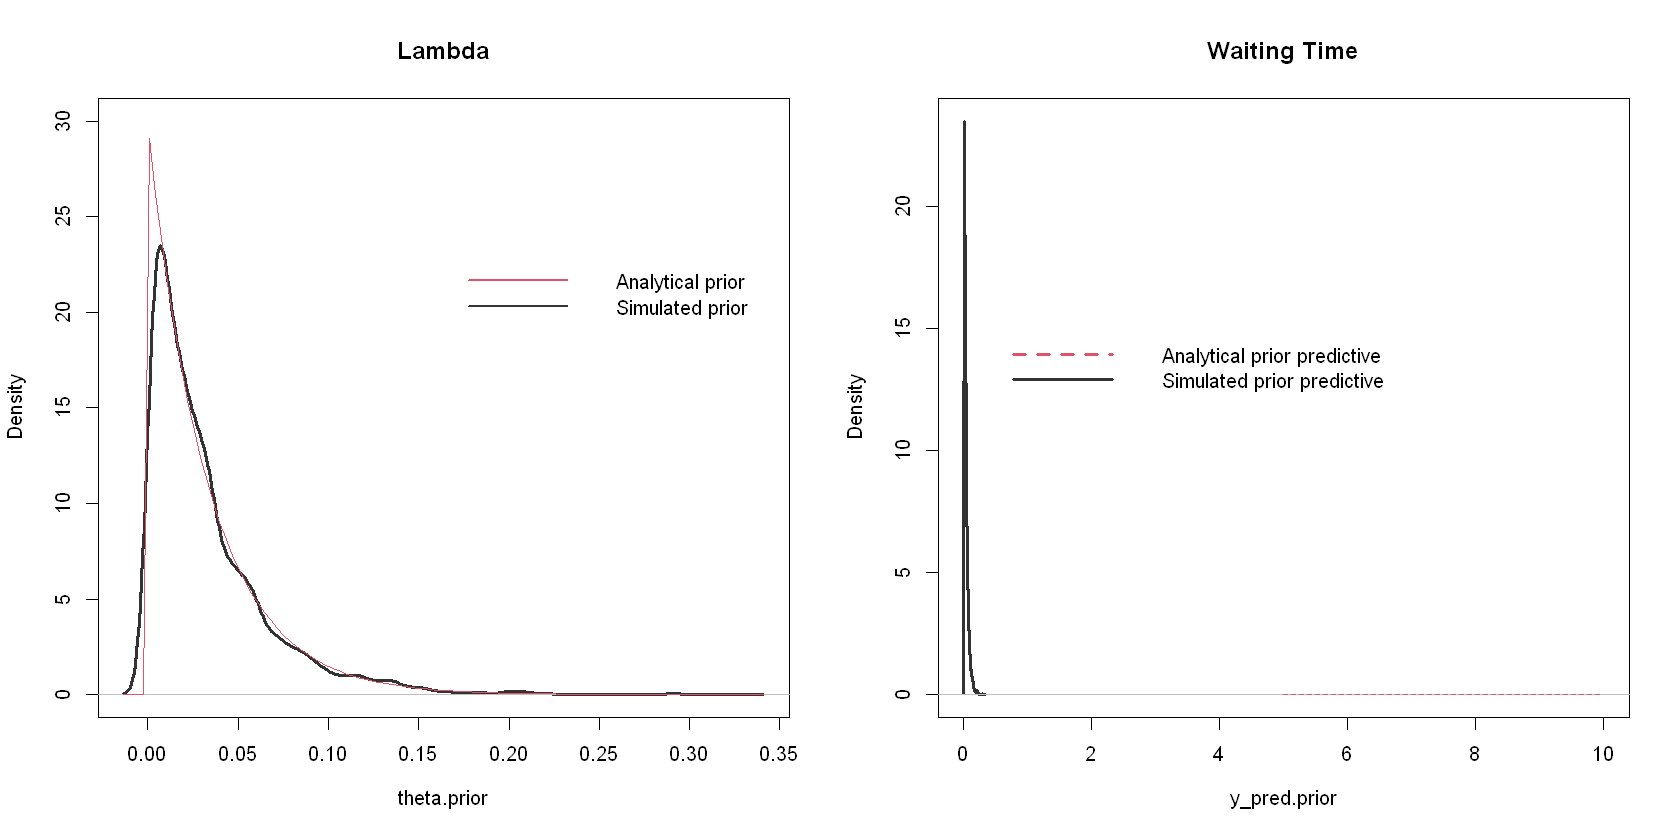

In [12]:
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))

plot(density(theta.prior), xlab=expression(theta.prior), col=grey(0, 0.8),lwd=3, main="Lambda", ylim=c(0, 30))
curve(dgamma(x, alpha.prior, beta.prior), add=TRUE, col=2)
legend(x=0.15,y=23,legend=c("Analytical prior", "Simulated prior"), col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=2)

x_lim <- c(0, 10)
plot(density(y_pred.prior), xlab=expression(y_pred.prior), col=grey(0, 0.8),lwd=3, xlim=x_lim, main="Waiting Time")
curve(dpareto(x, alpha.prior, beta.prior), add=TRUE, col=2, lwd=1.5, lty=2,5)
legend(x=x_lim[1] - x_lim[1] / 5, y=15, legend=c("Analytical prior predictive", "Simulated prior predictive"), 
       col=c(2, grey(0, 0.8)), lty=c(2,1), bty="n",lwd=3)

par(old.par)

Which seems to present some discrepancies in the case of the prior predictive pdf, but models relatively well the prior pdf. In fact, we could compare the expected value and variance obtained with the simulation, with respect to the analytical approach knowing that:

- For a $\lambda \sim \mathrm{Gamma}(\alpha, \beta)$:
$$\mathbb{E}[\lambda] = \frac{\alpha}{\beta}$$
$$\mathrm{Var}[\lambda] = \frac{\alpha}{\beta^2}$$

In [8]:
# analytical expected value and sd
lambda.prior.expectation <- alpha.prior / beta.prior
lambda.prior.variance <- alpha.prior / beta.prior^2
lambda.prior.sd <- sqrt(lambda.prior.variance)

round(lambda.prior.expectation, 4)
round(lambda.prior.sd, 4)

[1] 0.0333

[1] 0.0333

In [9]:
theta.prior.expectation <- mean(theta.prior)
theta.prior.sd <- sqrt(var(theta.prior))

round(theta.prior.expectation, 4)
round(theta.prior.sd, 4)

[1] 0.033

[1] 0.0341

Which are very close results! In a similar fashion, we know that:

- For $y \sim \expdist(\lambda) $ with the previously defined $\lambda$:
$$ \operatorname{E}(Y)=\dfrac{\beta}{\alpha-1},\mskip20mu\alpha>1,\mskip30mu $$
$$ \operatorname{var}(Y)=\dfrac{\beta^{2}\,\alpha}{(\alpha-1)^{2}\,(\alpha-2)},\mskip20mu \alpha>2, $$

But since our $\alpha = 1$ these expressions do not apply.

### 3 & 4: Simulation of the posterior pdf for $\lambda$, $p(\theta|x)$, and the posterior predictive pdf for $y$

Now, we want to perform simulations using Stan for:

3. The prior pdf for $\lambda$, with the new knowledge
4. The posterior (predictive) pdf for new waiting time, obtained from $p(\theta|x)$

To simulate the posterior pdf's we will need, apart from the prior knowledge, some observations. Thus, we will take the same observations' vector as the ``Exponential.02.Earthquake`` notebook's:

In [13]:
obs <- c(16, 8, 114, 60, 4, 23, 30, 105)
n <- length(obs)

Now, we define a model to simulate the posterior pdfs, in which $\theta$ will model $\lambda$ as parameter and the predictive pdf for $y$ will be obtained as 'generated quantity' $y_{\mathrm{pred}}$, but now $n$ and $y[n]$ will receive the observations to include them in the simulation:

In [14]:
posterior.pdf.stan.model.code <- "
data {
        real<lower=0> prior_a;
        real<lower=0> prior_b;

        int<lower=0> n;
        real<lower=0> y[n];
    }

parameters {
        real<lower=0.00001> theta;
    }

model {
        theta ~ gamma(prior_a,prior_b);
        y ~ exponential(theta);
    }

generated quantities {
        real y_pred;
        y_pred = exponential_rng(theta);
    }
    "

We compile the model

In [15]:
posterior.pdf.stan.Dso <- stan_model(model_code=posterior.pdf.stan.model.code)

Then, we pass the observations and prior knowledge:

In [16]:
posterior.dat <- list(n = n, y = obs, prior_a=alpha.prior, prior_b=beta.prior); 
posterior.fit <- sampling(posterior.pdf.stan.Dso, data = posterior.dat, iter = 15000, chains=1, warmup = 7000, thin = 1) 


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 15000 [  0%]  (Warmup)
Chain 1: Iteration:  1500 / 15000 [ 10%]  (Warmup)
Chain 1: Iteration:  3000 / 15000 [ 20%]  (Warmup)
Chain 1: Iteration:  4500 / 15000 [ 30%]  (Warmup)
Chain 1: Iteration:  6000 / 15000 [ 40%]  (Warmup)
Chain 1: Iteration:  7001 / 15000 [ 46%]  (Sampling)
Chain 1: Iteration:  8500 / 15000 [ 56%]  (Sampling)
Chain 1: Iteration: 10000 / 15000 [ 66%]  (Sampling)
Chain 1: Iteration: 11500 / 15000 [ 76%]  (Sampling)
Chain 1: Iteration: 13000 / 15000 [ 86%]  (Sampling)
Chain 1: Iteration: 14500 / 15000 [ 96%]  (Sampling)
Chain 1: Iteration: 15000 / 15000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.042 seconds (Warm-up)
Chain 1:                0.048 seconds (Sampling)
Ch

And we finally extract the results

In [17]:
theta.posterior <- extract(posterior.fit, 'theta')
theta.posterior <- unlist(theta.posterior, use.names=FALSE) # posterior lambda
y_pred.posterior <- extract(posterior.fit, 'y_pred')
y_pred.posterior <- unlist(y_pred.posterior, use.names=FALSE) # posterior predictive expecting time

#### Analytical comparison of the results

We can compare now our simulations with the analytical expressions taking advantage we are dealing with a conjugate model. Then, we know that the posterior pdf for $\lambda$ is also given by a $\mathrm{Gamma}$ distribution but with updated parameters. Namely, $\lambda\sim\operatorname{Gamma}(\alpha',\beta')$ with:

$$
    \left\{
    \begin{array}{lcl}
    \alpha'&=&\alpha+n,\\[0.2cm]
    \beta'&=&\beta+n\,\overline{y}.
    \end{array}\right.
$$

Let us define them:

In [18]:
ybar<-mean(obs)
nybar<-sum(obs)

alpha.posterior <- alpha.prior + n
beta.posterior <- beta.prior + nybar

And since the posterior $\lambda$ is distributed as a $\mathrm{\Gamma}$ we can recall the former expressions for the expected value and standard deviation:

In [19]:
lambda.posterior.expectation <- alpha.posterior / beta.posterior
lambda.posterior.variance <- alpha.posterior / beta.posterior^2
lambda.posterior.sd <- sqrt(lambda.posterior.variance)
round(lambda.posterior.expectation, 4)
round(lambda.posterior.sd, 4)

[1] 0.0231

[1] 0.0077

Which do not differ too much from the obtained from our simulations! 

In [20]:
theta.posterior.expectation <- mean(theta.posterior)
theta.posterior.sd <- sqrt(var(theta.posterior))

round(theta.posterior.expectation, 4)
round(theta.posterior.sd, 4)

[1] 0.0231

[1] 0.0076

Let us finally plot the posterior pdf both for $\lambda$ and the predictive pdf for the waiting time, comparing them with their analytical expressions:

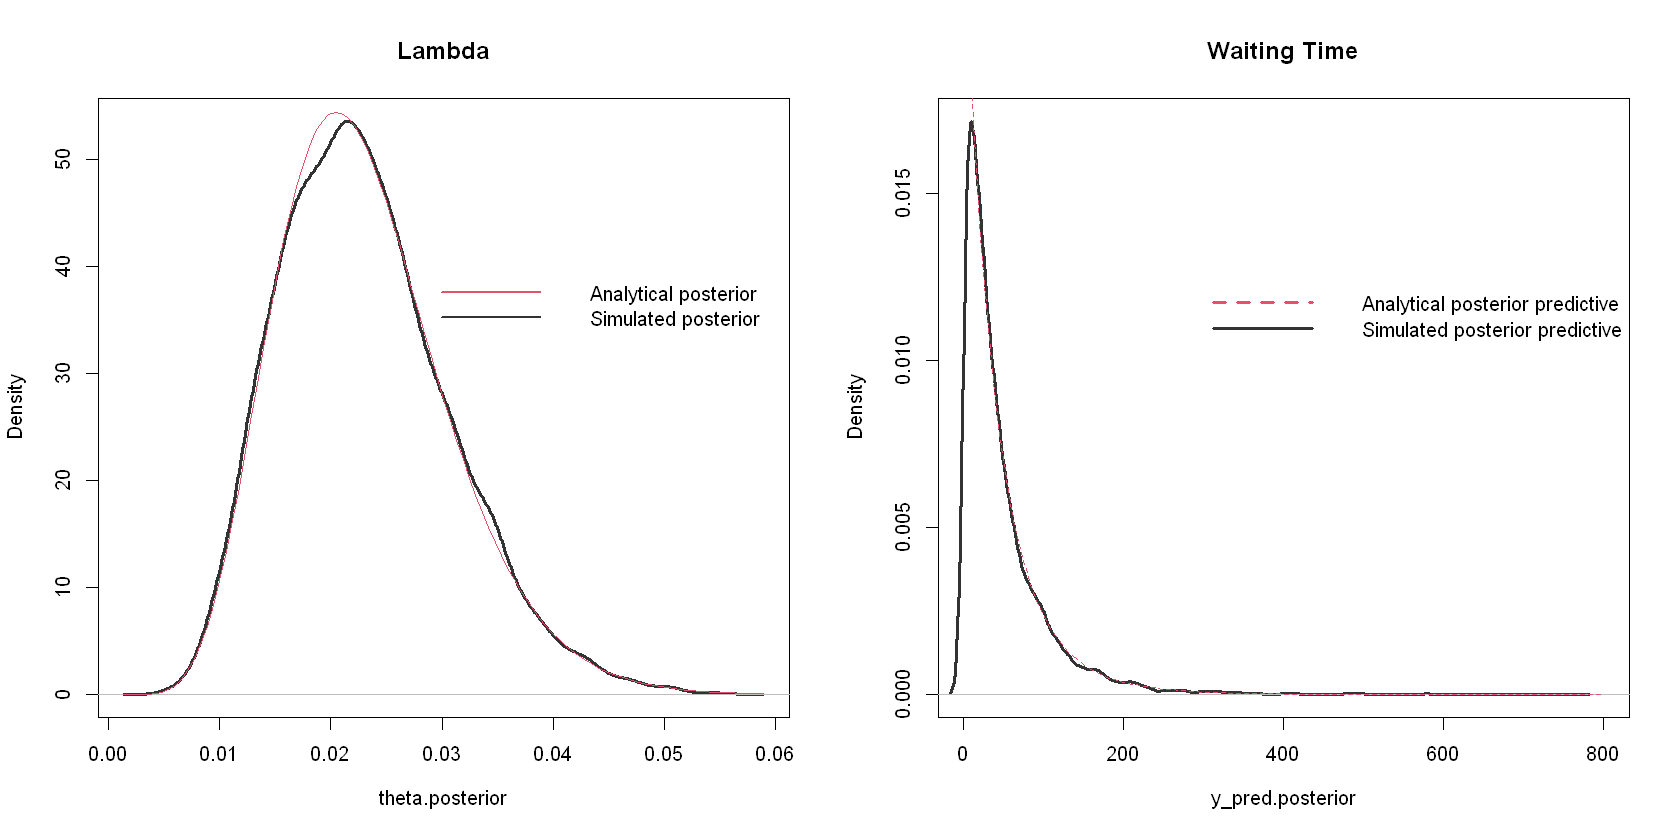

In [30]:
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))

plot(density(theta.posterior), xlab=expression(theta.posterior), col=grey(0, 0.8),lwd=3, main="Lambda")
curve(dgamma(x, alpha.posterior, beta.posterior), add=TRUE, col=2)
legend(x=0.0255,y=40,legend=c("Analytical posterior", "Simulated posterior"), col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=2)

plot(density(y_pred.posterior), xlab=expression(y_pred.posterior), col=grey(0, 0.8),lwd=3, xlim=c(0, 800), main="Waiting Time")
curve(dpareto(x, alpha.posterior, beta.posterior), add=TRUE, col=2, lwd=1.5, lty=2,5)
legend(x=250,y=0.0125,legend=c("Analytical posterior predictive", "Simulated posterior predictive"), 
       col=c(2, grey(0, 0.8)), lty=c(2,1), bty="n",lwd=3)

par(old.par)

Yielding a better fit!

### Improvements

The convergency and quality of the sampling process when there are observations can be improved by changing some parameters. The main idea is to use the warmup parameter to decrease the possibility of divergencies; however, this does not prevent the apparison of bias in the process. To reduce the bias and ensure the convergence does not depend on the particular simulation, the best idea is to increment the number of chains up to 2 or 3. This is what is done below with the posterior pdf's simulations:

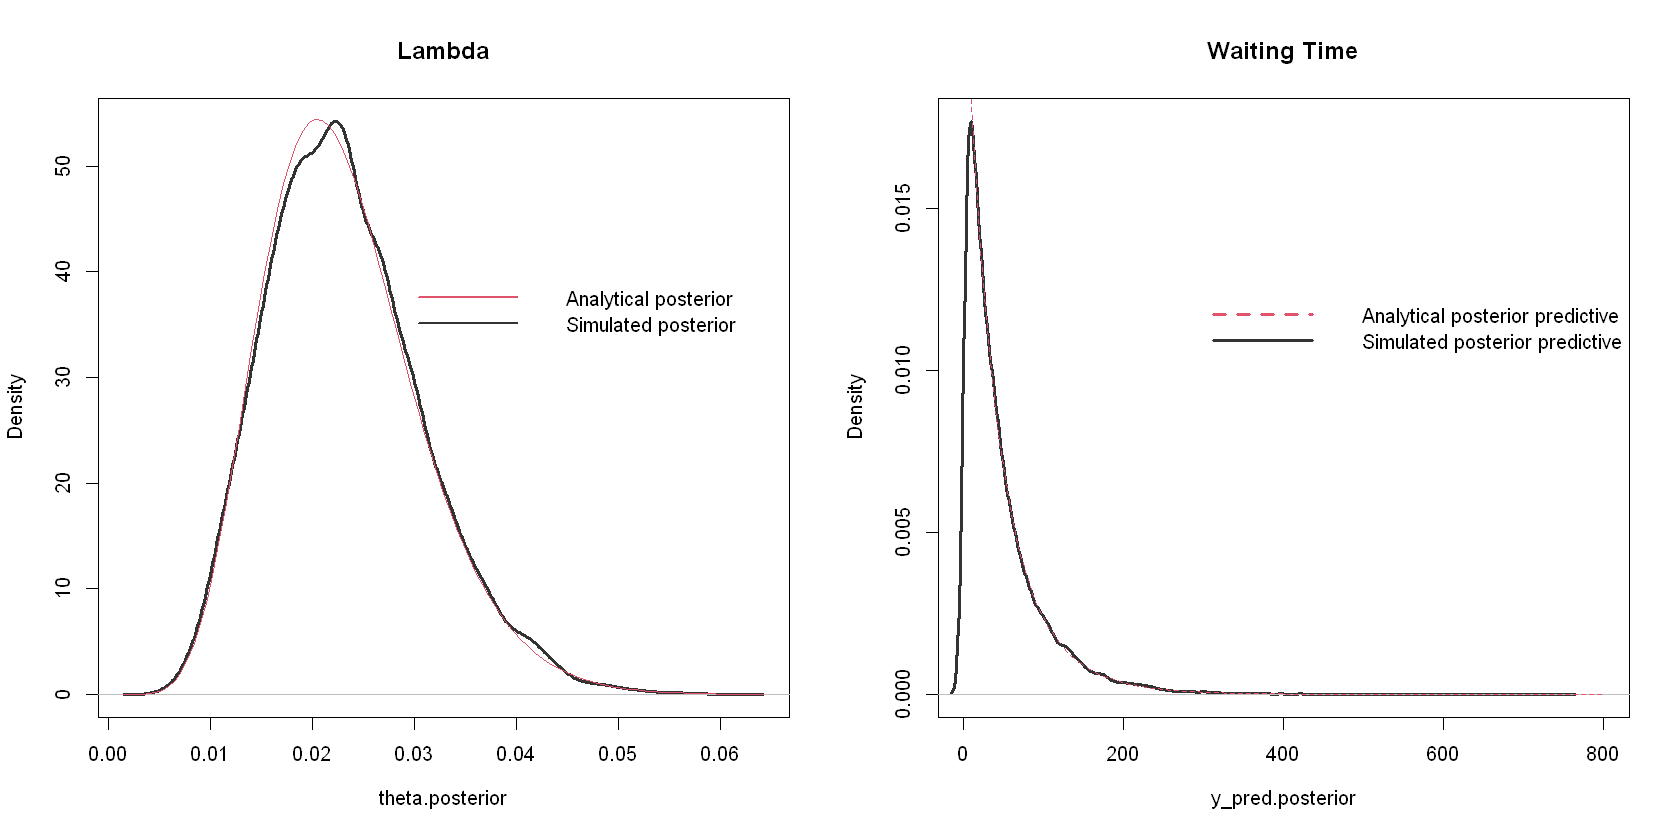

In [35]:
warm_up <- 10000
chains_num <- 3

##########################

posterior.dat <- list(n = n, y = obs, prior_a=alpha.prior, prior_b=beta.prior); 
posterior.fit <- sampling(posterior.pdf.stan.Dso, data = posterior.dat, iter = 15000, chains=chains_num, warmup = warm_up, thin = 1) 

theta.posterior <- extract(posterior.fit, 'theta')
theta.posterior <- unlist(theta.posterior, use.names=FALSE) # posterior lambda
y_pred.posterior <- extract(posterior.fit, 'y_pred')
y_pred.posterior <- unlist(y_pred.posterior, use.names=FALSE) # posterior predictive expecting time

options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))

plot(density(theta.posterior), xlab=expression(theta.posterior), col=grey(0, 0.8),lwd=3, main="Lambda")
curve(dgamma(x, alpha.posterior, beta.posterior), add=TRUE, col=2)
legend(x=0.0255,y=40,legend=c("Analytical posterior", "Simulated posterior"), col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=2)

plot(density(y_pred.posterior), xlab=expression(y_pred.posterior), col=grey(0, 0.8),lwd=3, xlim=c(0, 800), main="Waiting Time")
curve(dpareto(x, alpha.posterior, beta.posterior), add=TRUE, col=2, lwd=1.5, lty=2,5)
legend(x=250,y=0.0125,legend=c("Analytical posterior predictive", "Simulated posterior predictive"), 
       col=c(2, grey(0, 0.8)), lty=c(2,1), bty="n",lwd=3)

par(old.par)

---------------------------------------------------------------------------------------------------
# Exercise 2
---------------------------------------------------------------------------------------------------
## Statement

<h1 style="color:blue">02 - A more elaborate mixture prior for the spinning coin</h1>

(continued from Diaconis experiment)

On reflection, it was decided that tails had come up more often than heads in the past; further some coins seemed likely to be symmetric. 

Thus, a final approximation to the prior was taken as:

$$
    0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Same observed data as in the previous model.

In [31]:
# Number of trials
n<-10
# Observed x
x.obs<-3

Perform a complete Bayesian analysis of this model, in close parallel to the first example.

(1) Using the theoretical formulas (prior predictive pmf, posterior pdf, posterior predictive pmf)

(2) Using independent random numbers (`rbeta()` functions, etc.)

(3) JAGS version

(4)$ {}^{\star}$ Stan version. 

>$ (\star)$ Hint: this one **is difficult** due to intrinsic limitations in Stan:   
Stan does not allow integer parameters thus the JAGS code cannot be translated literally.  

>As a matter of fact even a Stan version of the two-components prior mixture in `Mixture.priors.01.Stan.ipynb` 
is tricky.   
There are several possible workarounds; try to find one but do not despair if you fail to develop a workable version.

Diaconis and Ylvisaker (1985) compare both mixture conjugate priors with a $ \operatorname{Unif}(0,1)$ prior with the data above. 

Comparing the MAP estimators, they observe that in a first approximation, they coincide, but spreads do depend on the prior.

They repeat the computations above with a larger sample. 

In [ ]:
n1<-50
x1.obs<-14

Their conclusion is that with small data, prior matters, but with larger samples, a finely tuned choice of prior is less important.

# The model

The model faced consists in a mixture of three Beta distributions becoming a Beta-Bernoulli model.

The objective is to learn that distribution from an independent sequence of experiments, so it can be modelled as a Binomial distribution of size `n` with probability defined by the Beta-Bernoulli distribution.

The likelihood is:
$$ x \sim \binomdist(\text{size}=n,\text{prob}=\theta)$$

with the prior distribution
$$ \theta \sim 0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10) $$


In [5]:
# Let's define the parameters of the mixture prior
prior.alpha1<-10
prior.beta1<-20
prior.alpha2<-15
prior.beta2<-15
prior.alpha3<-20
prior.beta3<-10
prior.gamma1<-0.5
prior.gamma2<-0.2
prior.gamma3<-0.3

# Define two functions to compute the pdf and cdf of that betas
mixture.prior.pdf<-function(theta){
    return(prior.gamma1*dbeta(theta,prior.alpha1,prior.beta1)+prior.gamma2*dbeta(theta,prior.alpha2,prior.beta2)+prior.gamma3*dbeta(theta,prior.alpha3,prior.beta3))
}
mixture.prior.cdf<-function(theta){
    return(prior.gamma1*pbeta(theta,prior.alpha1,prior.beta1)+prior.gamma2*pbeta(theta,prior.alpha2,prior.beta2)+prior.gamma3*pbeta(theta,prior.alpha3,prior.beta3))
}

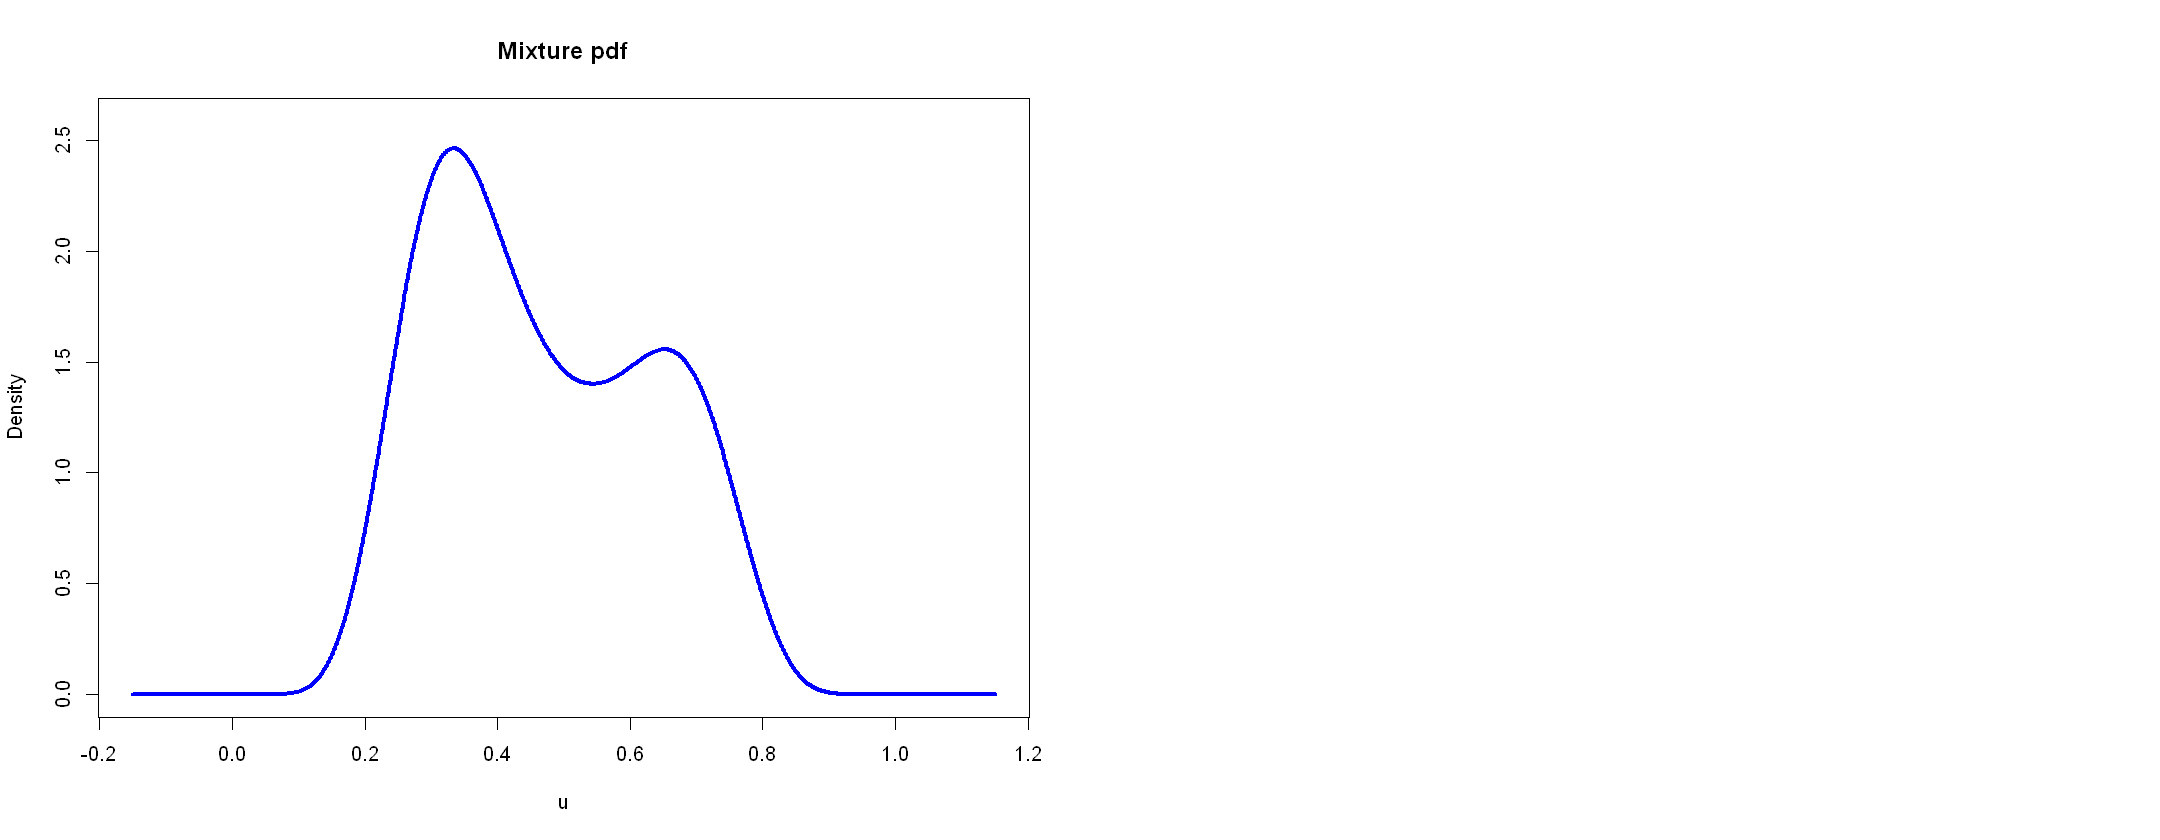

In [6]:
# And plot the Mixture pdf
options(repr.plot.width=18,repr.plot.height=7)
par(mfrow=c(1,2))
u<-seq(0,1,length=1000)
v<-mixture.prior.pdf(u)
plot(u,v,ylim=c(0,max(v)*1.05),xlim=c(-0.15,1.15),
     ylab="Density",type="l",lwd=3.5,col="blue",main=sprintf("Mixture pdf"))
lines(c(-0.15,0),c(0,0),lwd=3.5,col="blue")
lines(c(1,1.15),c(0,0),lwd=3.5,col="blue")

-------------------------------------------------------------------------------
# Exercise 2
-------------------------------------------------------------------------------

## Solution

### 4. Model's bayesian analysis: using Stan

Henceforth, it is presented generalization of the Stan model for 3-components mixture for:
1. The posterior pdf, $\theta$
2. The posterior predictive pdf, $x$

The main limitation is that Stan is unable to simulate discrete parameters, so we will generalize the trick presented at `Mixture.priors.01.Stan` notebook consisting in generating (on the spot) the index selecting which of both components in the mixture is chosen.

In [7]:
require(rstan)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

We saw that for 2 components one natural workaround is to define $u\sim\unifdist(0,1)$ and $\gamma\in(0,1)$, such that $u$ will be the unnamed index selecting which of both components in the mixture is chosen (because $\prob(u<\gamma)=\gamma$). 

Now, for 3 components, we can define the same index but with 2 $\gamma_i$ and we make $P$ depend on it with using the ternary infix conditional operator **twice**.

Namely, we pass the 2 $\gamma_i$: ``real<lower=0,upper=1>  gamma1 ;`` and ``real<lower=0,upper=1>  gamma2 ;`` as data (the third one is determined since $\gamma_1 + \gamma_2 + \gamma_3 = 1$), and then $P$ is one of the 3 $\theta_i$ depending on the index. We can combine the conditional operator twice in the following fashion:

``p = theta[u < gamma1 ? 1 : (u < gamma2 ? 2 : 3)] ;``

Below, the Stan model's code is defined. Note, it is the same code as ``Mixture.priors.01.Stan`` but with the former changes (and, of course, now $\theta$ is passed as parameter as a **3-component** vector: ``vector<lower=0, upper=1>[3] theta;``, being ``theta[3] ~ beta(a3,b3);``):

In [11]:
posterior.mixture.stan.model.code = "
    data{
        int<lower=0> n ;
        int<lower=0> x ; 
        real<lower=0> a1 ;
        real<lower=0> b1 ;
        real<lower=0> a2 ;
        real<lower=0> b2 ;
        real<lower=0> a3 ;
        real<lower=0> b3 ;
        real<lower=0,upper=1>  gamma1 ;
        real<lower=0,upper=1>  gamma2 ;
        }
    parameters{
        real<lower=0,upper=1>  u ;
        vector<lower=0,upper=1>[3] theta ;
        }
    transformed parameters{                         
        real<lower=0,upper=1> p ;                   
        p = theta[u < gamma1 ? 1 : (u < gamma2 ? 2 : 3)] ;
        }
    model{
        x ~ binomial(n,p) ;
        theta[1]~beta(a1,b1) ;
        theta[2]~beta(a2,b2) ;
        theta[3]~beta(a3,b3) ;
        u ~ uniform(0,1) ; 
        }"

In [13]:
posterior.mixture.stan.Dso <- stan_model(
    model_code = posterior.mixture.stan.model.code) 

And to perform the sampling, we load as data the prior knowledge and the same number of trials and observed x as those of `Mixture.priors.01.Stan`.

Below, these are defined as list and, then,  the `sampling` executed:

In [18]:
n<-10  # number of trials
x.obs<-3  # observed x

posterior.mixture.stan.dat <- list(
    a1=prior.alpha1,b1=prior.beta1,a2=prior.alpha2,b2=prior.beta2,
    b3=prior.beta3,a3=prior.alpha3,gamma1=prior.gamma1,gamma2=prior.gamma2,
    gamma3=prior.gamma3,n=n,x=x.obs)

posterior.mixture.stan.fit <- sampling(
    object=posterior.mixture.stan.Dso, data = posterior.mixture.stan.dat, 
    chains = 2, iter = 4000, warmup = 200, thin = 1)

These are the obtained results:

In [19]:
posterior.mixture.stan.results <- summary(posterior.mixture.stan.fit)
round(posterior.mixture.stan.results$summary, 3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
u,0.301,0.005,0.215,0.014,0.134,0.274,0.416,0.906,1882.632,1.000
theta[1],0.325,0.001,0.077,0.183,0.270,0.321,0.376,0.488,3547.053,1.000
theta[2],0.502,0.001,0.088,0.332,0.441,0.503,0.562,0.674,5222.710,1.000
theta[3],0.659,0.002,0.089,0.474,0.599,0.665,0.723,0.818,2904.221,1.001
p,0.351,0.002,0.109,0.188,0.277,0.334,0.400,0.635,2937.696,1.000
lp__,-68.912,0.037,1.686,-73.052,-69.773,-68.545,-67.664,-66.796,2111.486,1.000


And similarly to exercise 1, we extract the parameters from the fit using the ``extract`` function:

In [21]:
p.posterior <- extract(posterior.mixture.stan.fit, 'p')
p.posterior <- unlist(p.posterior, use.names=FALSE)

theta1.posterior <- extract(posterior.mixture.stan.fit, 'theta[1]')
theta1.posterior <- unlist(theta1.posterior, use.names=FALSE)
theta2.posterior <- extract(posterior.mixture.stan.fit, 'theta[2]')
theta2.posterior <- unlist(theta2.posterior, use.names=FALSE)
theta3.posterior <- extract(posterior.mixture.stan.fit, 'theta[3]')
theta3.posterior <- unlist(theta3.posterior, use.names=FALSE)

### Analysis of the posterior pdf simulations

Finally, below we carry out the same analysis of the posterior pdfs' properties in the same fashion as performed in `Mixture.priors.01.Stan`

In [30]:
require(bayesplot, quietly=TRUE)
params_ <- c("p", "theta[1]", "theta[2]", "theta[3]")

#### Posterior credible interval 

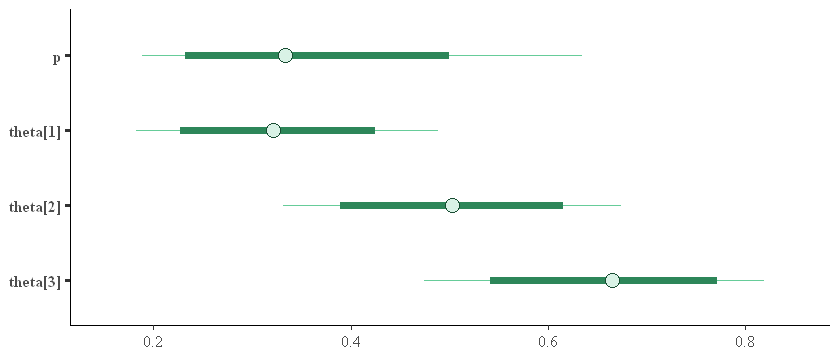

In [31]:
color_scheme_set("green")
options(repr.plot.width=7,repr.plot.height=3)
mcmc_intervals(posterior.mixture.stan.fit, pars = params_, prob=0.80, prob_outer=0.95)

#### Areas diagram

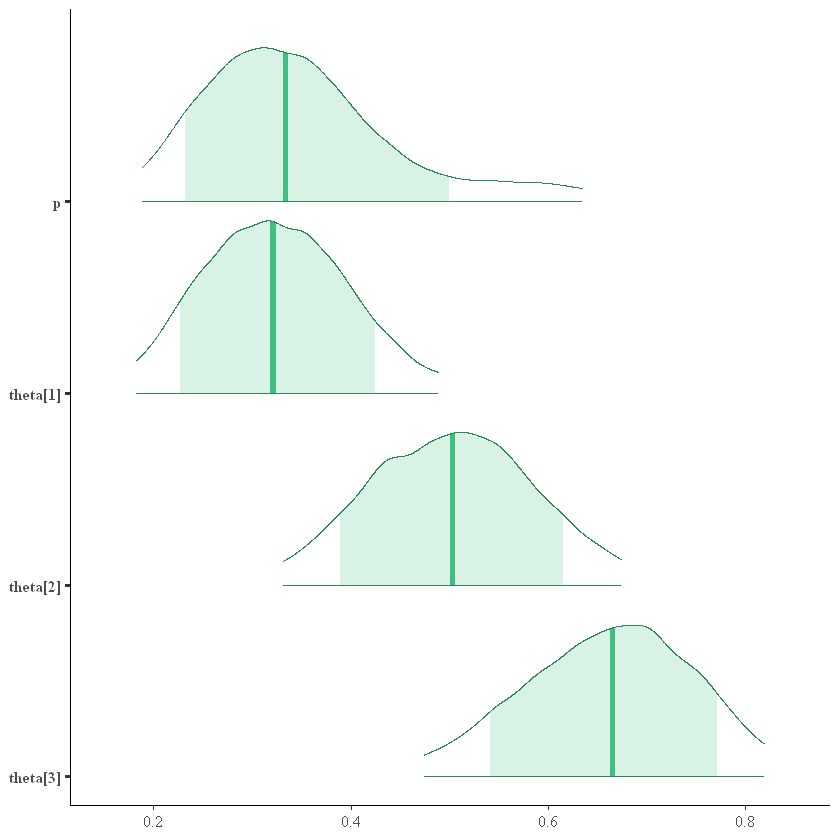

In [32]:
color_scheme_set("green")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_areas(posterior.mixture.stan.fit, pars = params_, prob=0.80,prob_outer=0.95)

#### Histogram

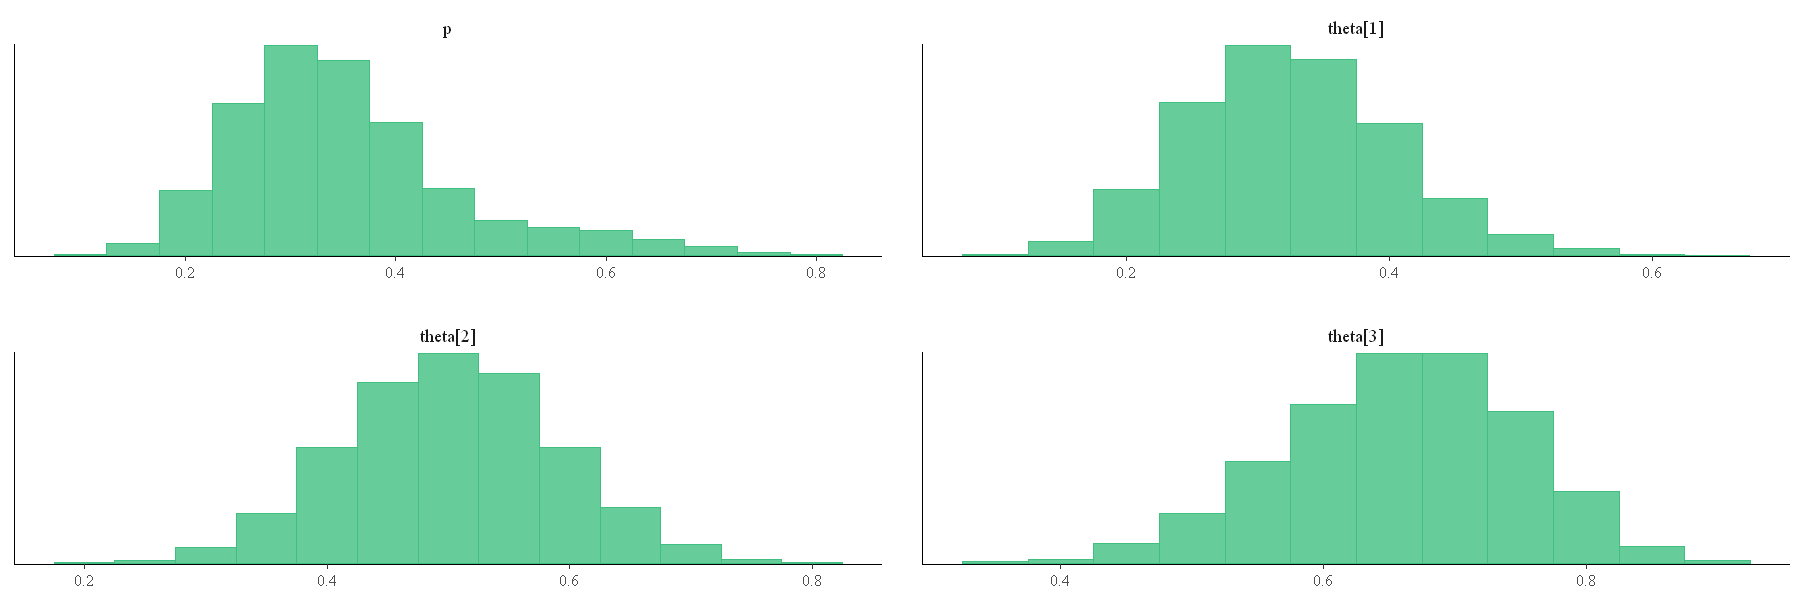

In [33]:
color_scheme_set("green")
options(repr.plot.width=15,repr.plot.height=5)
mcmc_hist(posterior.mixture.stan.fit, pars = params_, binwidth=0.05)

#### Density plot

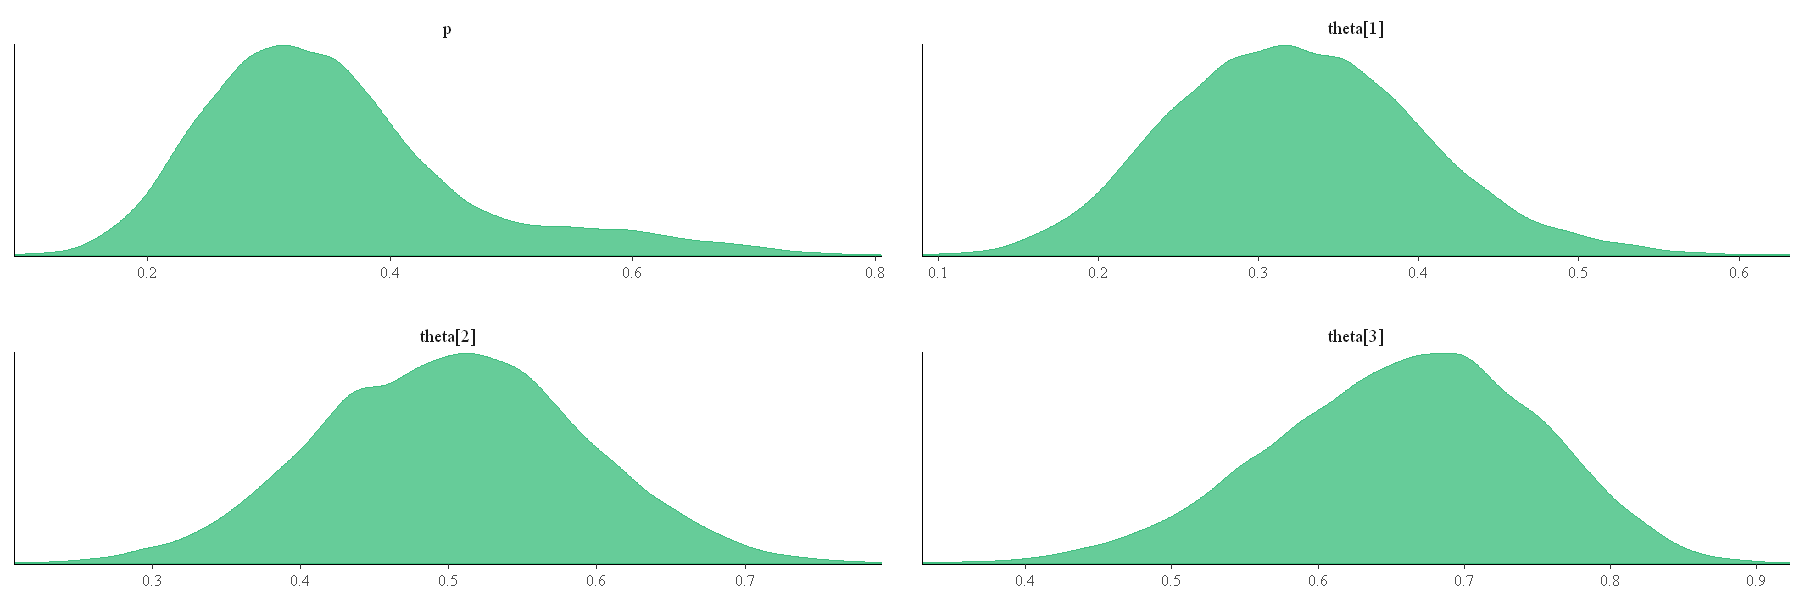

In [34]:
options(repr.plot.width=15,repr.plot.height=5)
mcmc_dens(posterior.mixture.stan.fit, pars = params_)

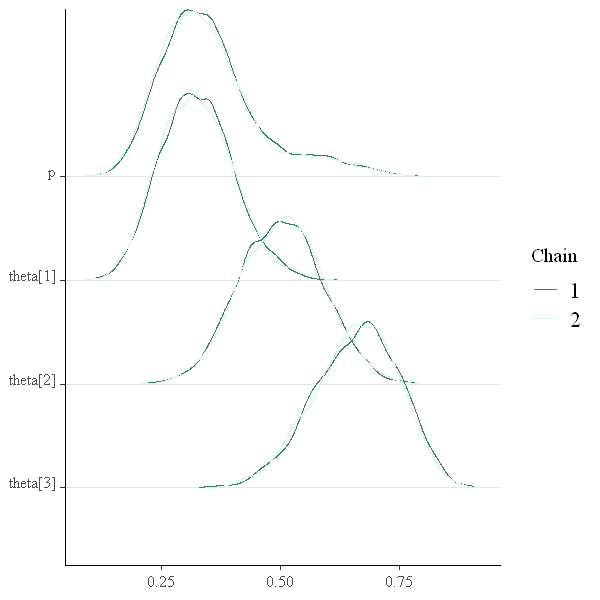

In [35]:
color_scheme_set("green")
options(repr.plot.width=5,repr.plot.height=5)
mcmc_dens_chains(posterior.mixture.stan.fit, pars = params_)

(Note that just 2 chains were used before because of CPU limitations)

#### Violin plot

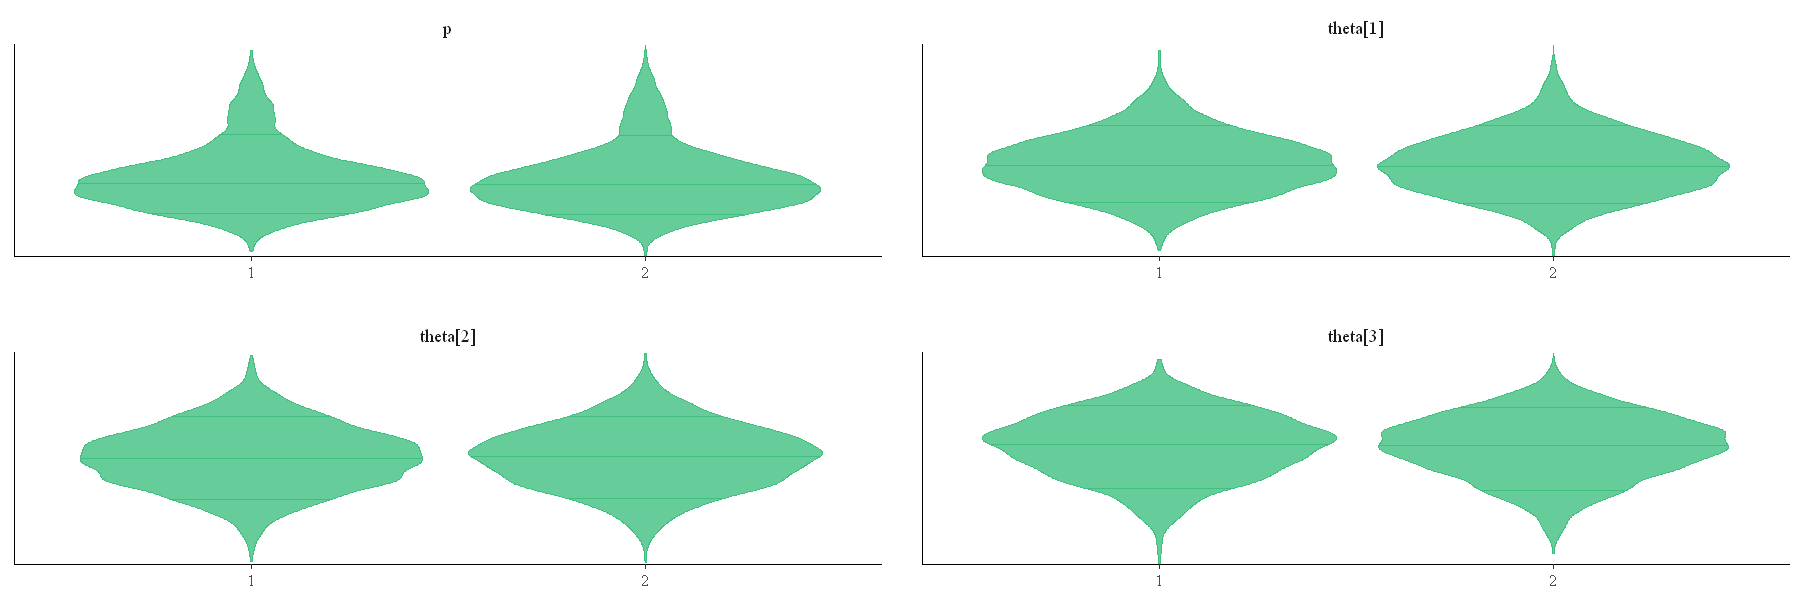

In [36]:
color_scheme_set("green")
options(repr.plot.width=15,repr.plot.height=5)
mcmc_violin(posterior.mixture.stan.fit, pars = params_)